In [1]:
import matplotlib.pyplot as plt
import skimage as sk
from skimage import data, io, filters, color
from skimage.transform import rescale, resize, downscale_local_mean
import pandas as pd
import numpy as np
from math import floor

In [2]:
img = io.imread('data/1.png')
img = color.rgb2gray(img)
img = rescale(img, 0.08, anti_aliasing=False, anti_aliasing_sigma=7)
img = ((img*2).round()/2).astype(int)

In [390]:
img = io.imread('data/6.png')
img = color.rgb2gray(img)
img = rescale(img, 1/12, anti_aliasing=False, anti_aliasing_sigma=7)
img = ((img*2).round()/2).astype(int)

In [228]:
img = io.imread('data/6.png')
img = color.rgb2gray(img)
img = rescale(img, 1/12, anti_aliasing=False, anti_aliasing_sigma=7)
img = ((img*2).round()/2).astype(int)

In [43]:
img.shape

(16, 16)

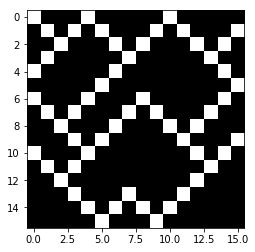

In [44]:
plt.imshow(img, cmap='gray')

Take a 3x3 patch and turn into sequence, treat each entry as categorical variance and compute covariance matrix between each pair

In [4]:
def ndim2flat_idx(idx, shape):
    """
    Inverse to np.unravel_index.
    
    E.g. ndim2flat_idx([1,2], (3,3)) = 5
    """
    flat_idx = 0
    place = 1
    for i in range(len(idx))[::-1]:
        if idx[i] >= shape[i]:
            raise ValueError('Index too big for shape!')
        flat_idx += idx[i]*place
        place = place*shape[i]
    return flat_idx

oh wait Im counting if matches self oops

In [589]:
# num loops = 64*64*50*50 = 10 million

def compute_count_tensor(img, kernel_size, stride, dilation=0):
    """
    Currently kernel size is also stride.
    """
    
    indices = [[i,j] for i in range(kernel_size) for j in range(kernel_size)]
    
    w = img.shape[1]
    h = img.shape[0]
    num_convs_w = floor((w-kernel_size)/stride)+1
    num_convs_h = floor((w-kernel_size)/stride)+1
    
    count_tensor = np.zeros([kernel_size**2,
                             kernel_size**2, 2,2])
    for i in range(0, num_convs_h, stride):
        for j in range(0, num_convs_w, stride):
            for idx1 in indices:
                for idx2 in indices:

                    idx = (
                        ndim2flat_idx(idx1, (kernel_size,kernel_size)),
                        ndim2flat_idx(idx2, (kernel_size,kernel_size)),
                        img[i + idx1[0], j + idx1[1]],
                        img[i + idx2[0], j + idx2[1]]
                    )

                    if idx1 != idx2:
                        count_tensor[idx] = count_tensor[idx] + 1
                        
    return count_tensor

def normalize_count_tensor(count_tensor):
    normalized_tensor = count_tensor / np.sum(count_tensor, axis=(2,3), keepdims=True)
    affinity_tensor = np.log(normalized_tensor + 0.0000001)
    return affinity_tensor
        
        
count_tensor = compute_count_tensor(img, kernel_size=4, stride=1)
affinity_tensor = normalize_count_tensor(count_tensor)

/Users/milesturpin/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in true_divide


In [351]:
np.swapaxes(np.swapaxes(count_tensor, 0,2), 1,3).round(2)

array([[[[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 1., ..., 0., 1., 1.],
         [0., 1., 0., ..., 0., 1., 1.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 1., 1., ..., 0., 0., 1.],
         [0., 1., 1., ..., 0., 1., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [1., 0., 0., ..., 1., 0., 0.],
         [1., 0., 0., ..., 1., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [1., 0., 0., ..., 1., 0., 0.],
         [1., 0., 0., ..., 1., 0., 0.]]],


       [[[0., 1., 1., ..., 0., 1., 1.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 1., 1., ..., 0., 1., 1.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 1., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [1., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0.

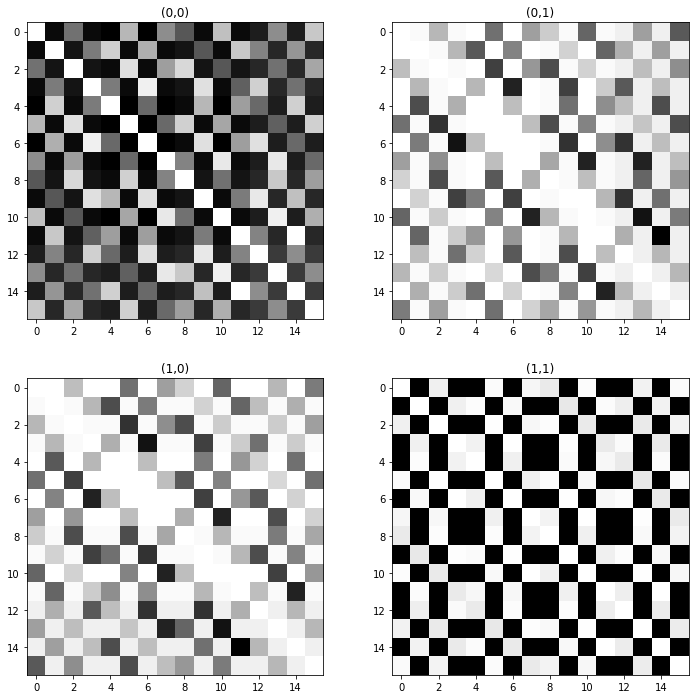

In [590]:
fig, axes = plt.subplots(2,2, figsize=(12,12))
for i in range(2):
    for j in range(2):
        axes[i,j].imshow(affinity_tensor[:,:,i,j], cmap='gray')
        axes[i,j].set_title(f'({i},{j})')

In [510]:
floor((16-4)/2)+1

7

In [534]:
2 * np.arange(7)

array([ 0,  2,  4,  6,  8, 10, 12])

In [591]:
def calc_total_log_prob(affinity_tensor, img, kernel_size, stride):
    
    w = img.shape[1]
    h = img.shape[0]
    num_convs_w = floor((w-kernel_size)/stride)+1
    num_convs_h = floor((w-kernel_size)/stride)+1
    
    log_prob = 0
    cnt2 = 0
    for i in stride * np.arange(num_convs_h):
        #print('i', i)
        for j in stride * np.arange(num_convs_w):
            #print('j', j)
            local_prob, cnt = calc_log_prob(affinity_tensor, img, i, j, kernel_size)
            log_prob = log_prob + local_prob
            #print(cnt)
            cnt2 += cnt
                    
    return log_prob, cnt2

def calc_log_prob(affinity_tensor, img, i, j, kernel_size):
    
    indices = [[i,j] for i in range(kernel_size) for j in range(kernel_size)]
    log_prob = 0
    #res = []
    #res2 = []
    cnt = 0
    for pos1 in range(16):
        # plus 1 so that no collisions
        for pos2 in range(pos1+1, 16):
            idx1 = indices[pos1]
            idx2 = indices[pos2]
            #print(idx1, idx2)

            idx = (
                pos1, 
                pos2,
                img[i + idx1[0], j + idx1[1]],
                img[i + idx2[0], j + idx2[1]]
            )
            
            if idx1 != idx2:
                #res.append(int(affinity_tensor[idx]))
                #res2.append({(i,j, ndim2flat_idx(idx1, (kernel_size,kernel_size)),
                #            ndim2flat_idx(idx2, (kernel_size,kernel_size))) :int(affinity_tensor[idx])})
                log_prob = log_prob + affinity_tensor[idx]
                cnt+=1
                    
    return log_prob, cnt
#, res, res2

In [596]:
calc_total_log_prob(affinity_tensor, img, 4, 1)

(-20154.492237574534, 20280)

In [593]:
calc_total_log_prob(affinity_tensor, np.zeros((16,16)).astype(int), 4,1)

(-10211.131067387303, 20280)

(-11929.030404303096, 20280)


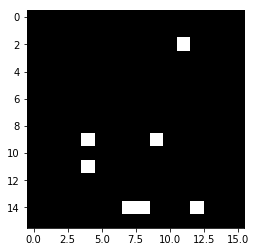

In [595]:
arr = (np.random.rand(16,16) < 0.05).astype(int)       
print(calc_total_log_prob(affinity_tensor, arr, 4,1))
plt.imshow(arr, cmap='gray')

In [154]:
calc_total_log_prob(affinity_tensor, (np.zeros((16,16))+1).astype(int), 4)

-49064.11417021296

-20264.842141236186


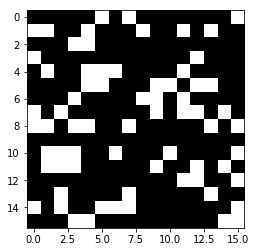

In [155]:
arr = (np.random.rand(16,16) < 0.2).astype(int)
print(calc_total_log_prob(affinity_tensor, arr, 4))
plt.imshow(arr, cmap='gray')

In [156]:
#count_tensor[2,4].flatten() / count_tensor[2,4].flatten().sum()

In [157]:
# total = []
# other = []
# for i in range(img.shape[0]-2):
#     for j in range(img.shape[1]-2):
        
#         total.append([img[i + idx[0], j + idx[1]] for idx in indices])
#         other += [[idx[0], idx[1], ] for idx in indices]

scan across the image, at every location, look at all pairwise combinations of pixels in the window, and add a count to the co-occurence values 

[idx, data] size (3^2 * (width-2)^2, 4)
0, 6, 0, 1
0, 4, 1, 0

or

[pos1, pos2, conv_filter_idx]

-> [pos1, pos2, value1, value2] = count; size (9, 9, 2, 2)

In [158]:
calc_log_prob(affinity_tensor, img, 9, 9, 4)

-171.4119594134845

In [159]:
np.random.rand()

0.4336758440171742

In [ ]:
np.array(
        [kernel_size*floor(a/kernel_size), 
        kernel_size*floor(b/kernel_size)])

In [327]:
# stride=2
# kernel_size=3
# floor((6-kernel_size)/stride)+1

2

In [368]:
# stride=2
# kernel_size=4
# num_convs_h = floor((20-kernel_size)/stride)+1
# print(num_convs_h)
# print(stride*np.random.randint(num_convs_h))

9
12


In [597]:


def mcmc_step(affinity_tensor, img, beta, kernel_size, stride):
    '''Monte Carlo step using Metropolis algorithm '''
    
    # Get the kernel indices that we're calculating energy for
    h=img.shape[0]
    w=img.shape[1]
    #kernel_idx = np.array(
    #    [kernel_size*floor(a/kernel_size), 
    #    kernel_size*floor(b/kernel_size)])
    num_convs_w = floor((w-kernel_size)/stride)+1
    num_convs_h = floor((h-kernel_size)/stride)+1
    
    # Multiply stride by sample from number of filters to get idx of corner
    kernel_idx = np.array([
        stride*np.random.randint(num_convs_h),
        stride*np.random.randint(num_convs_w)])
        
    # Random positions relative to sequence
    pos1 = np.random.randint(kernel_size**2)
    pos2 = np.random.randint(kernel_size**2)
    # Get relative indices in window
    idx1 = np.unravel_index(pos1, (kernel_size,kernel_size))
    idx2 = np.unravel_index(pos2, (kernel_size,kernel_size))
    abs_idx1 = tuple(kernel_idx + idx1)
    abs_idx2 = tuple(kernel_idx + idx2)
    
    
    # Calc current log_prob for sampled window
    log_prob, cnt = calc_total_log_prob(
       affinity_tensor, img, kernel_size, stride)
    #print(cnt)
    #, res1, res11
#     log_prob = calc_log_prob(
#         affinity_tensor, img, kernel_idx[0], kernel_idx[1], kernel_size)

    # Get current config for pos1 and pos2 and propose new config
    # Accept config with some probability
    current_config = [img[abs_idx1], img[abs_idx2]]
    
    modded_img = img.copy()
    #modded_img[abs_idx1] = np.random.randint(2)
    #modded_img[abs_idx2] = np.random.randint(2)
    
    # just make sure you dont sample old config
    sample_config = lambda: [np.random.randint(2), np.random.randint(2)]
    proposal_config = sample_config()
    while proposal_config == current_config:
        proposal_config = sample_config()
    modded_img[abs_idx1] = proposal_config[0]
    modded_img[abs_idx2] = proposal_config[1]
    
    # Proposal log_prob
    modded_log_prob, cnt2 = calc_total_log_prob(
       affinity_tensor, modded_img, kernel_size, stride)
    #print(cnt2)
    #print('mod')
    #, res2, res22
#     modded_log_prob = calc_log_prob(
#         affinity_tensor, modded_img, kernel_idx[0], kernel_idx[1], kernel_size)

    
    log_diff = modded_log_prob - log_prob

    #print(list(zip(res1, res2)))
    #print([i==j for (i,j) in list(zip(res1, res2))])
    #print(len(res1)-sum([i==j for (i,j) in list(zip(res1, res2))]))
    #print(np.where([i!=j for (i,j) in list(zip(res1, res2))]))
    #print(np.array(res11)[np.where([i!=j for (i,j) in list(zip(res1, res2))])[0]])
    #print(np.array(res22)[np.where([i!=j for (i,j) in list(zip(res1, res2))])[0]])
    
    #print(kernel_size, stride)
    #print(kernel_idx)
    #print(pos1, pos2, idx1, idx2)
    #print(abs_idx1, abs_idx2)
    #print('current', current_config)
    #print('mod', modded_img[abs_idx1], modded_img[abs_idx2])
    ##
    #print(log_prob, modded_log_prob)
    #print('log diff', log_diff)
    #print(np.exp(log_diff*beta))

    # If higher likelihood then keep
    if log_diff >= 0:
        #print('accept!')
        return modded_img, 1, modded_log_prob
    # if lower likelihood, accept with some prob
    elif np.random.rand() < np.exp(log_diff*beta):
        #print('accept!')
        return modded_img, 1, modded_log_prob
    else:
        #print('reject :(')
        return img, 0, log_prob


def calcEnergy(config):
    '''Energy of a given configuration'''
    energy = 0
    for i in range(len(config)):
        for j in range(len(config)):
            S = config[i,j]
            nb = config[(i+1)%N, j] + config[i,(j+1)%N] + config[(i-1)%N, j] + config[i,(j-1)%N]
            energy += -nb*S
    return energy/4.


def calcMag(config):
    '''Magnetization of a given configuration'''
    mag = np.sum(config)
    return mag

In [598]:
# 3
np.random.seed(5)
mcmc_step(affinity_tensor, img, beta=0.05, kernel_size=4, stride=1)

(array([[1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1],
        [0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0],
        [0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0],
        [1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0],
        [0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0],
        [0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0],
        [0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1],
        [1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0],
        [0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]]),
 0,
 -20154.492237574534)

In [608]:
#np.random.seed(4)

samps = []
accepts = []
probs = []

img_samp = np.random.randint(2, size=img.shape)
#img_samp = np.zeros((16,16)).astype(int)

tot_steps = 1000
upper_beta=10
lower_beta=0.5

# Take down temperature over time
betas = np.linspace(lower_beta, upper_beta, tot_steps)
for step in range(tot_steps):
    
    img_samp, accept, log_prob = mcmc_step(
        affinity_tensor, img_samp, beta=betas[step], kernel_size=4, stride=1)
    #betas[step]
    samps.append(img_samp)
    accepts.append(accept)
    probs.append(log_prob)
    
#     if step == tot_steps:
#         print(step)
    

In [609]:
print(sum(accepts)/len(accepts))

0.142


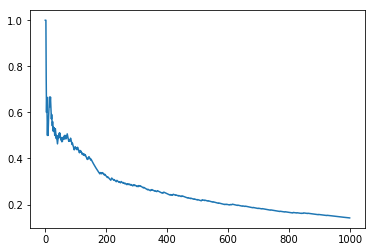

In [610]:
accept_df = pd.Series(accepts).cumsum().reset_index()
(accept_df[0]/(accept_df['index']+1)).plot()


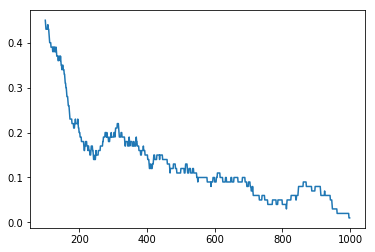

In [611]:
accept_df = pd.Series(accepts).rolling(100).sum().reset_index()
(accept_df[0]/100).plot()


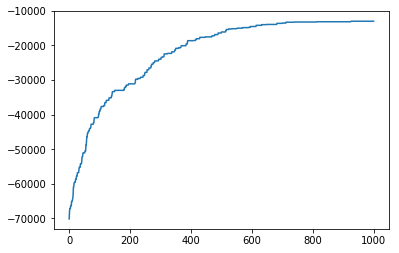

In [612]:
plt.plot(probs)

In [613]:
from matplotlib import animation, rc
from IPython.display import HTML

In [614]:
calc_total_log_prob(affinity_tensor, samps[-1], 4,2)

(-4088.3047578435844, 5880)

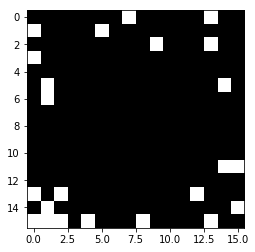

In [615]:
plt.imshow(samps[-1],cmap='gray')

In [587]:
import datetime

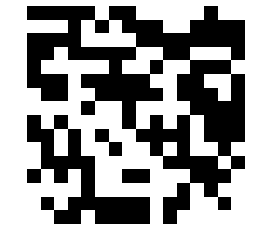

In [588]:
fig, ax = plt.subplots(1,1, figsize=(4,4))

#im = ax.imshow(samps[0])
ax.axis('off')

num_frames=min(50, len(samps))
frame_idx = np.round(
    np.linspace(0, len(samps)-1, num_frames)).astype(int)

def init():
    im.set_array(samps[0])
    return im

def animate(i):
    #print(i)
    #ax.clear()
    ax.imshow(samps[frame_idx[i]], cmap='gray')
    #im.set_array(samps[i])

anim = animation.FuncAnimation(
    fig, animate, 
    frames=num_frames-1, 
    #init_func=init, 
    interval=75) 

directory = datetime.datetime.now().strftime("%m%d%y_%H%M%S")
anim.save(f'gifs/{directory}.gif', writer='imagemagick')

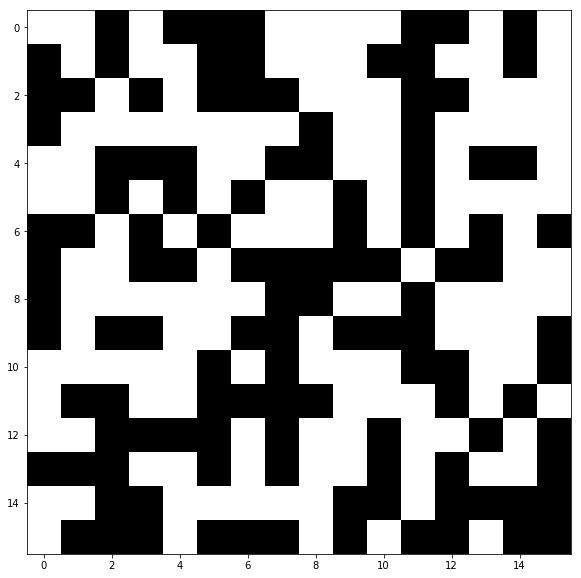

In [75]:
HTML(anim.to_jshtml())

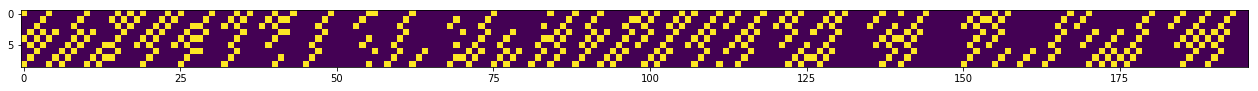

In [138]:
plt.figure(figsize=(22,5))
plt.imshow(np.array(total).T, )

In [146]:
for i in range(len(df.columns)):
    df.loc[:,i] = df.loc[:,i].astype('category')

In [149]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 196 entries, 0 to 195
Data columns (total 9 columns):
0    196 non-null category
1    196 non-null category
2    196 non-null category
3    196 non-null category
4    196 non-null category
5    196 non-null category
6    196 non-null category
7    196 non-null category
8    196 non-null category
dtypes: category(9)
memory usage: 2.6 KB


In [150]:
df = pd.DataFrame(total)

pd.crosstab(df, columns=df.columns)

TypeError: 'int' object is not iterable